In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import tensorflow as tf
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))
import glob
from tqdm import tqdm
import cv2
from PIL import ImageDraw,Image
traindf=pd.read_csv('../input/training/training.csv')
testdf=pd.read_csv('../input/test/test.csv')
from keras.layers.advanced_activations import LeakyReLU

['test', 'IdLookupTable.csv', 'SampleSubmission.csv', 'training']


Using TensorFlow backend.


In [194]:
columns=[i for i in traindf.columns if 'eye_center' in i or 'nose' in i or'bottom_lip' in i]

In [169]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [170]:
traindf.shape

(7049, 31)

In [171]:
X_train=np.stack([np.array(list(map(int,i.split(" ")))).reshape((96,96)) for i in traindf.Image])
X_test=np.stack([np.array(list(map(int,i.split(" ")))).reshape((96,96)) for i in testdf.Image])



In [195]:
img=X_train[16].astype(np.float32)
m=traindf.loc[2,columns]

In [196]:
m

left_eye_center_x            65.0571
left_eye_center_y            34.9096
right_eye_center_x           30.9038
right_eye_center_y           34.9096
nose_tip_x                   47.5573
nose_tip_y                   53.5389
mouth_center_bottom_lip_x    47.2749
mouth_center_bottom_lip_y    78.6594
Name: 2, dtype: object

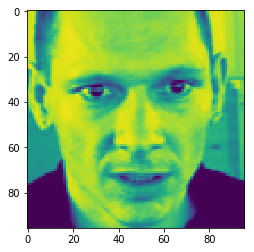

In [197]:
a=Image.fromarray(img)
draw=ImageDraw.Draw(a)
plt.imshow(a)

In [198]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)

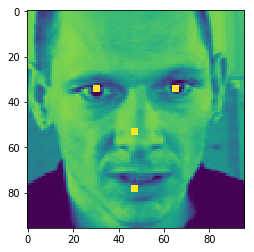

In [199]:
plt.imshow(a)

In [200]:
X_train1=X_train.astype(np.float32)/255

In [201]:
Ytrain=traindf.loc[:,columns]
    


In [202]:
X_train1.shape

(7049, 96, 96)

In [206]:
indexes=Ytrain[pd.isna(Ytrain).any(axis=1)].index


In [208]:
X=np.delete(X_train1,indexes,axis=0)

In [209]:
X.shape

(7000, 96, 96)

In [227]:
Y=Ytrain.dropna(axis=0)


In [228]:
Y.shape

(7000, 8)

In [230]:
Y=Y.values

In [231]:
Y=Y.astype(np.float32)

In [232]:
Y.shape

(7000, 8)

In [233]:
X.shape

(7000, 96, 96, 1)

In [223]:
X=X.reshape((-1,96,96,1))

In [225]:
X.shape

(7000, 96, 96, 1)

In [224]:
#Making Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,BatchNormalization,InputLayer
from keras.models import Model,Sequential

In [234]:
model=Sequential()
model.add(InputLayer((96,96,1)))
model.add(Conv2D(16,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(128,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(8))                     # Mistake fixed removed softmax since we are not normalizing the probability its a regression 
model.compile(loss='mse',optimizer='adam')

/opt/conda/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [235]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 96, 96, 16)        160       
_________________________________________________________________
batch_normalization_21 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
activation_21 (Activation)   (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_22 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_22 (Activation)   (None, 48, 48, 32)        0         
__________

In [236]:
history = model.fit(X,Y,epochs=100,batch_size=32)

Epoch 1/100
7000/7000 [==============================] - 4s 545us/step - loss: 167.8203
Epoch 2/100
7000/7000 [==============================] - 2s 337us/step - loss: 10.9389
Epoch 3/100
7000/7000 [==============================] - 2s 341us/step - loss: 8.4894
Epoch 4/100
7000/7000 [==============================] - 2s 337us/step - loss: 7.2843
Epoch 5/100
7000/7000 [==============================] - 2s 336us/step - loss: 6.3998
Epoch 6/100
7000/7000 [==============================] - 2s 339us/step - loss: 5.8690
Epoch 7/100
7000/7000 [==============================] - 2s 336us/step - loss: 5.2874
Epoch 8/100
7000/7000 [==============================] - 2s 337us/step - loss: 4.9121
Epoch 9/100
7000/7000 [==============================] - 2s 336us/step - loss: 4.4281
Epoch 10/100
7000/7000 [==============================] - 2s 340us/step - loss: 4.1654
Epoch 11/100
7000/7000 [==============================] - 2s 338us/step - loss: 4.0158
Epoch 12/100
7000/7000 [=========================

7000/7000 [==============================] - 2s 337us/step - loss: 0.7167
Epoch 96/100
7000/7000 [==============================] - 2s 336us/step - loss: 0.7615
Epoch 97/100
7000/7000 [==============================] - 2s 336us/step - loss: 0.8500
Epoch 98/100
7000/7000 [==============================] - 2s 339us/step - loss: 0.8449
Epoch 99/100
7000/7000 [==============================] - 2s 337us/step - loss: 0.7392
Epoch 100/100
7000/7000 [==============================] - 2s 341us/step - loss: 0.7660


In [241]:
Xtest1=X_test[0:10].astype(np.float32)/255
Xtest1=Xtest1.reshape((-1,96,96,1))

In [242]:
ypred=model.predict(Xtest1)

In [244]:
ypred

array([[68.42293 , 40.648445, 31.32189 , 38.82413 , 50.606194, 55.107697,
        49.206154, 88.355446],
       [71.43724 , 38.558178, 28.268354, 39.335754, 52.105152, 62.139687,
        52.447483, 91.65094 ],
       [68.617195, 38.772655, 32.56009 , 40.464546, 50.404873, 59.25434 ,
        50.41061 , 85.40568 ],
       [68.77582 , 39.971745, 32.35911 , 41.228123, 50.532772, 55.12233 ,
        51.26473 , 85.21943 ],
       [68.823044, 38.735256, 29.800077, 40.465687, 51.874535, 56.974617,
        53.11865 , 88.04351 ],
       [71.07716 , 39.099857, 29.145071, 38.546062, 49.93799 , 54.977085,
        50.559647, 90.757225],
       [69.67876 , 34.859585, 26.867296, 36.20166 , 52.929394, 57.917606,
        51.19121 , 85.88781 ],
       [70.32129 , 37.610233, 31.119106, 37.5959  , 52.890495, 55.61387 ,
        52.852123, 86.62949 ],
       [68.21773 , 41.12201 , 33.20292 , 39.67828 , 49.906445, 60.766594,
        48.537426, 89.014015],
       [68.67934 , 37.846973, 31.277067, 36.47356 , 51.

In [245]:
m=ypred[0]
xtest1=Xtest1[0].astype(np.float32)*255.0       # have to multiply image with 255 otherwise image is shown to be black
xtest1=xtest1.reshape((96,96))

In [246]:
a=Image.fromarray(xtest1)
draw=ImageDraw.Draw(a)

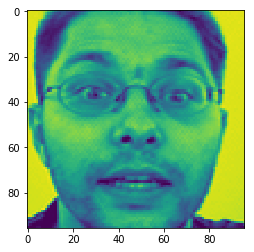

In [247]:
plt.imshow(xtest1)

In [248]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)

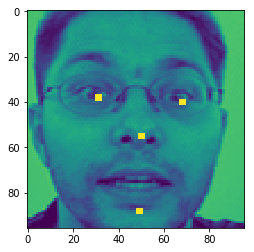

In [249]:
plt.imshow(a)  # with MSE  worked good

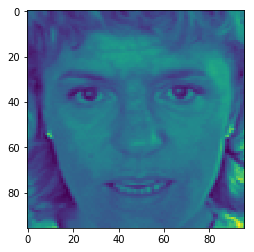

In [250]:
m=ypred[1]
xtest1=Xtest1[1].astype(np.float32)*255.0       # have to multiply image with 255 otherwise image is shown to be black
xtest1=xtest1.reshape((96,96))
a=Image.fromarray(xtest1)
draw=ImageDraw.Draw(a)
plt.imshow(xtest1)

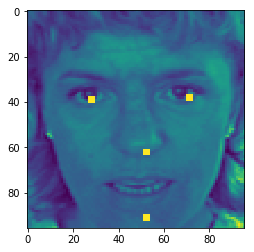

In [251]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)
    
plt.imshow(a) 

In [252]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [253]:
columns=[i for i in traindf.columns if 'eyebrow' in i or 'corner' in i or 'top_lip' in i]

In [254]:
columns

['left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y']

In [255]:
#Eye /eyebrow /mouth classifier
Y=traindf.loc[:,columns]

In [257]:
indexes=Y[pd.isna(Y).any(axis=1)].index

In [258]:
Xtrain3=np.delete(X_train1,indexes,axis=0)

In [259]:
Xtrain3.shape

(2155, 96, 96)

In [260]:
Y=Y.dropna(axis=0)

In [261]:
Y.shape

(2155, 22)

In [262]:
x1=Xtrain3[1]*255
m=Y.iloc[1,:]

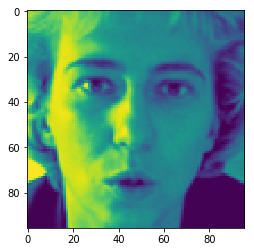

In [263]:
plt.imshow(x1)

In [264]:
x1=Image.fromarray(x1)
draw=ImageDraw.Draw(x1)
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)

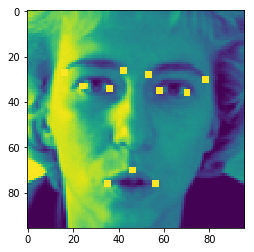

In [265]:
plt.imshow(x1)

In [266]:
Xtrain3=Xtrain3.astype(np.float32)

In [276]:
Xtrain3.shape

(2155, 96, 96, 1)

In [267]:
Xtrain3=Xtrain3.reshape((-1,96,96,1))

In [273]:
Y=Y.values
Y=Y.astype(np.float32)

In [275]:
Y.shape

(2155, 22)

In [277]:
model1=Sequential()
model1.add(InputLayer((96,96,1)))
model1.add(Conv2D(16,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(128,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(22))                     # Mistake fixed removed softmax since we are not normalizing the probability its a regression 
model1.compile(loss='mse',optimizer='adam')

/opt/conda/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [278]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 96, 96, 16)        160       
_________________________________________________________________
batch_normalization_31 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
activation_31 (Activation)   (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_32 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_32 (Activation)   (None, 48, 48, 32)        0         
__________

In [280]:
history = model1.fit(Xtrain3,Y,epochs=100,batch_size=32)

Epoch 1/100
2155/2155 [==============================] - 1s 392us/step - loss: 0.2892
Epoch 2/100
2155/2155 [==============================] - 1s 339us/step - loss: 0.2581
Epoch 3/100
2155/2155 [==============================] - 1s 343us/step - loss: 0.2831
Epoch 4/100
2155/2155 [==============================] - 1s 344us/step - loss: 0.3040
Epoch 5/100
2155/2155 [==============================] - 1s 348us/step - loss: 0.3325
Epoch 6/100
2155/2155 [==============================] - 1s 341us/step - loss: 0.2836
Epoch 7/100
2155/2155 [==============================] - 1s 342us/step - loss: 0.2442
Epoch 8/100
2155/2155 [==============================] - 1s 340us/step - loss: 0.2675
Epoch 9/100
2155/2155 [==============================] - 1s 348us/step - loss: 0.3188
Epoch 10/100
2155/2155 [==============================] - 1s 340us/step - loss: 0.3344
Epoch 11/100
2155/2155 [==============================] - 1s 341us/step - loss: 0.2934
Epoch 12/100
2155/2155 [============================

2155/2155 [==============================] - 1s 358us/step - loss: 0.1592
Epoch 96/100
2155/2155 [==============================] - 1s 380us/step - loss: 0.1909
Epoch 97/100
2155/2155 [==============================] - 1s 343us/step - loss: 0.1568
Epoch 98/100
2155/2155 [==============================] - 1s 348us/step - loss: 0.1472
Epoch 99/100
2155/2155 [==============================] - 1s 343us/step - loss: 0.1330
Epoch 100/100
2155/2155 [==============================] - 1s 390us/step - loss: 0.1327


In [281]:
Xtest1.shape

(10, 96, 96, 1)

In [282]:
ypred=model1.predict(Xtest1)

In [283]:
x=Xtest1[5].reshape((96,96))*255

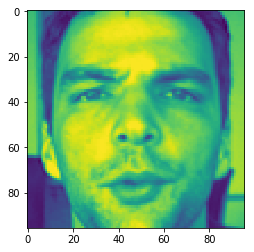

In [284]:
plt.imshow(x)

In [285]:
m=ypred[5]

In [286]:
m

array([59.761623, 35.88294 , 76.583   , 37.20068 , 37.089962, 36.58521 ,
       20.645063, 38.518692, 56.17257 , 29.98824 , 81.05498 , 28.374134,
       39.587017, 29.91998 , 14.599173, 30.877968, 65.07676 , 74.86875 ,
       32.320324, 76.66035 , 48.85681 , 71.412415], dtype=float32)

In [287]:
x1=Image.fromarray(x)

In [288]:
draw=ImageDraw.Draw(x1)

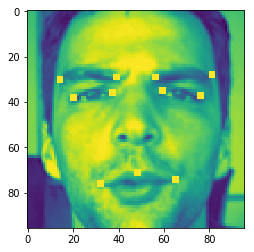

In [289]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)
    
plt.imshow(x1) 

In [292]:
df=pd.read_csv('../input/IdLookupTable.csv')

In [295]:
df

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
5,6,1,left_eye_inner_corner_y,NaN
6,7,1,left_eye_outer_corner_x,NaN
7,8,1,left_eye_outer_corner_y,NaN
8,9,1,right_eye_inner_corner_x,NaN
9,10,1,right_eye_inner_corner_y,NaN


In [296]:
traindf.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')